<a href="https://colab.research.google.com/github/chayma011/DAVG/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
from pathlib import Path
import os
from random import randint
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score

# Tensorflow and Keras
from tensorflow.keras import models
from tensorflow.keras.models import Model
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D
import keras.preprocessing as kp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.datasets import cifar10
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
import zipfile
import os

# Specify file paths
zip_path = "/content/drive/MyDrive/archive.zip"
extract_path = "/content/drive/MyDrive/CHAYMA"

# Create destination folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")


Extraction completed!


In [4]:
# Disable warnings
warnings.filterwarnings("ignore")

In [5]:
# Load Datasets
train_path = '/content/drive/MyDrive/CHAYMA/dataset_9010/dataset_9010/malimg_dataset/train'
valid_path = '/content/drive/MyDrive/CHAYMA/dataset_9010/dataset_9010/malimg_dataset/validation'
test_path = '/content/drive/MyDrive/CHAYMA/validation_ds_update_924/validation_ds_update_924/malimg_dataset/test'

In [6]:
# ImageDataGenerator with augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1.0/255.0,
    horizontal_flip=True,
    vertical_flip=False
)

In [7]:
gen_train = aug.flow_from_directory(train_path, target_size=(224, 224), batch_size=64, class_mode='categorical', color_mode="rgb")
gen_valid = aug.flow_from_directory(valid_path, target_size=(224, 224), batch_size=64, class_mode='categorical', color_mode="rgb")
gen_test = aug.flow_from_directory(test_path, target_size=(224, 224), batch_size=64, class_mode='categorical', color_mode="rgb")

Found 8404 images belonging to 25 classes.
Found 935 images belonging to 25 classes.
Found 924 images belonging to 25 classes.


In [8]:
# get images and label of images from training dataset use for display some of dataset.
imgs, labels = next(gen_train)

In [9]:
# create label dictionary to use it know the type of malware (model use index(number not text))
label_dict = {value:key for key, value in gen_train.class_indices.items()}

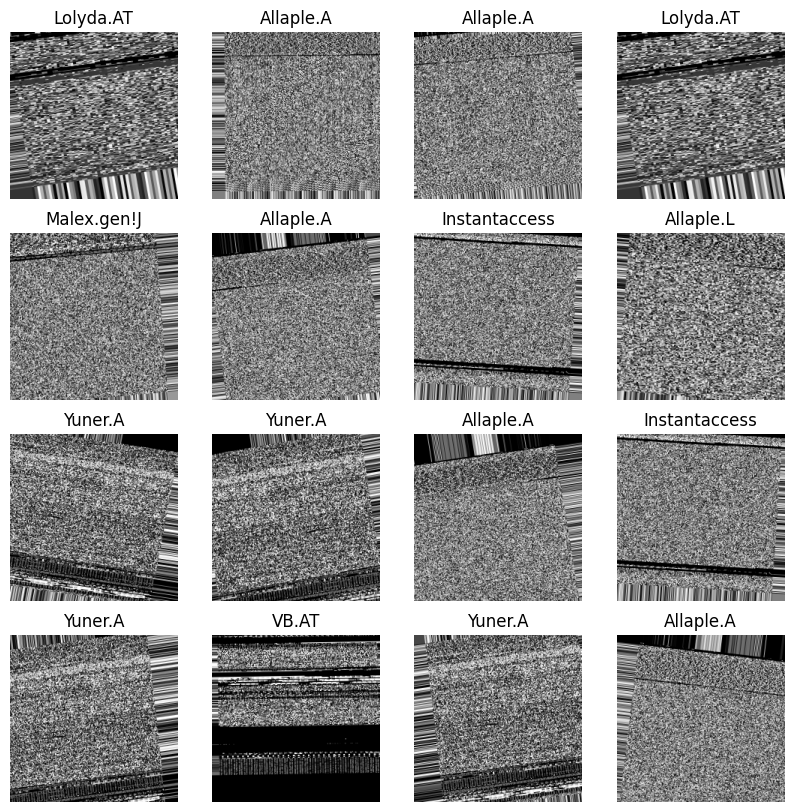

In [10]:
# create subplot for some sample of train data.
fig, ax = plt.subplots(4,4,figsize=(10,10))

# loop on new image predict and display.
for row in range(16):
    i = row//4
    j = row%4
    rand_index = randint(0, labels.shape[0]-1)
    ax[i, j].imshow(imgs[rand_index])
    ax[i, j].set_title(label_dict[np.where(labels[rand_index]!=0)[0][0]])
    ax[i, j].axis('off')

plt.show()

In [11]:
# Create VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(25, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg16_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 14,990,169 (57.18 MB)

 Trainable params: 275,481 (1.05 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
# Fit the model
history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(gen_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

y_pred = model.predict(gen_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = gen_test.classes
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.4134 - loss: 2.1841 - val_accuracy: 0.5390 - val_loss: 1.6704
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.7843 - loss: 0.8982 - val_accuracy: 0.7401 - val_loss: 1.0309
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8617 - loss: 0.5804 - val_accuracy: 0.7733 - val_loss: 0.8056
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8796 - loss: 0.4621 - val_accuracy: 0.8075 - val_loss: 0.6385
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8955 - loss: 0.3948 - val_accuracy: 0.8310 - val_loss: 0.5547
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9054 - loss: 0.3427 - val_accuracy: 0.8342 - val_loss: 0.5070
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9109 - loss: 0.3069 - val_accuracy: 0.8396 - val_loss: 0.4637
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9179 - loss: 0.2858 - val_accu

In [14]:
# calculate test accuracy and loss.
test_loss, test_acc = model.evaluate(gen_test, steps=50)
print('Test Accuracy:', round(test_acc*100,2),"%")
print('Test Loss:',test_loss)

50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 382ms/step - accuracy: 0.9264 - loss: 0.1625
Test Accuracy: 92.53 %
Test Loss: 0.16381046175956726


In [15]:
val_loss, val_acc = model.evaluate(gen_valid, steps=50)
print('val Accuracy:', round(val_acc*100,2),"%")
print('val Loss:',val_loss)

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 317ms/step - accuracy: 0.9424 - loss: 0.1548
val Accuracy: 93.69 %
val Loss: 0.16340087354183197


In [17]:
model.load_weights('./best_vgg16_model.keras')

In [18]:
imgs, labels = next(gen_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


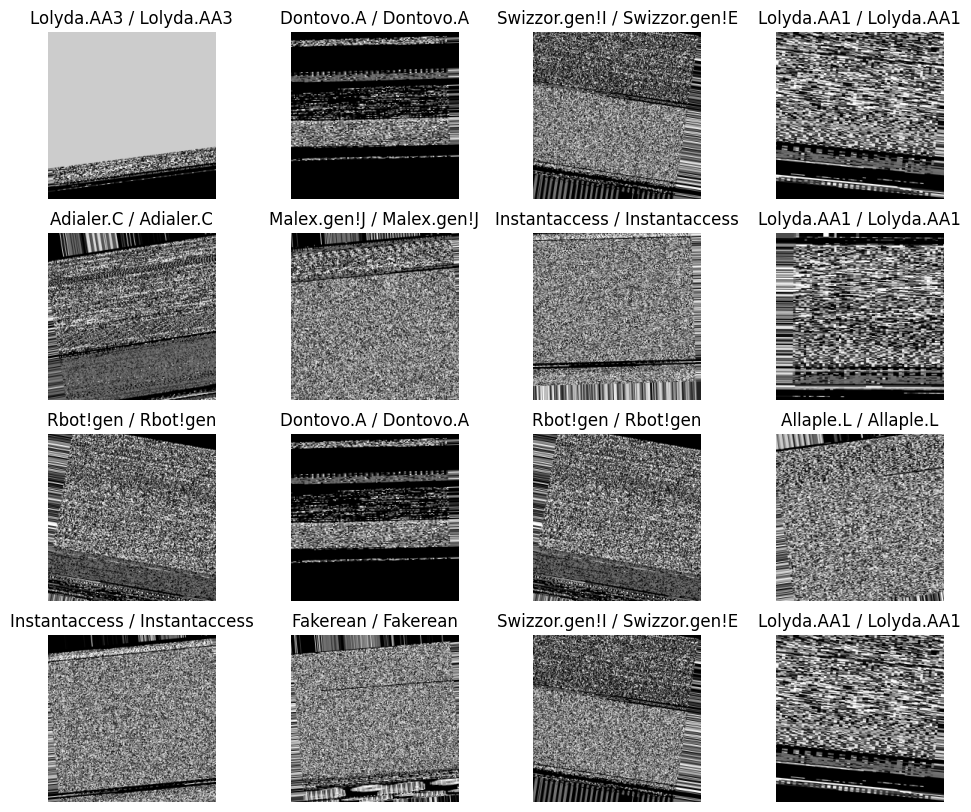

In [19]:
# create subplot for outside image.
fig, ax = plt.subplots(4,4,figsize=(12,10))

# loop on new image predict and display.
for row in range(16):
    i = row//4
    j = row%4
    rand_index = randint(0, labels.shape[0]-1)
    ax[i, j].imshow(imgs[rand_index])
    label_key = np.argmax(model.predict(np.expand_dims(imgs[rand_index],axis=0)))
    ax[i, j].set_title(label_dict[label_key]+" / "+label_dict[np.where(labels[rand_index]!=0)[0][0]])
    ax[i, j].axis('off')

plt.show()

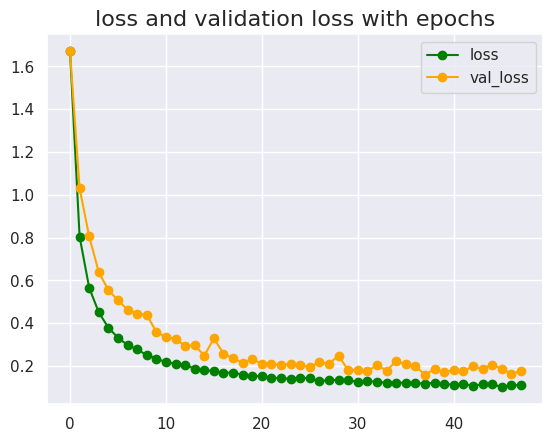

In [20]:
sns.set()
# plot loss function for train and validation.
plt.title('loss and validation loss with epochs',
          fontsize=16)

plt.plot(history.history['loss'],
         marker='o',
         color="green",
         label="loss")

plt.plot(history.history['val_loss'],
         marker='o',
         color="orange",
         label="val_loss")

plt.legend()
plt.show()

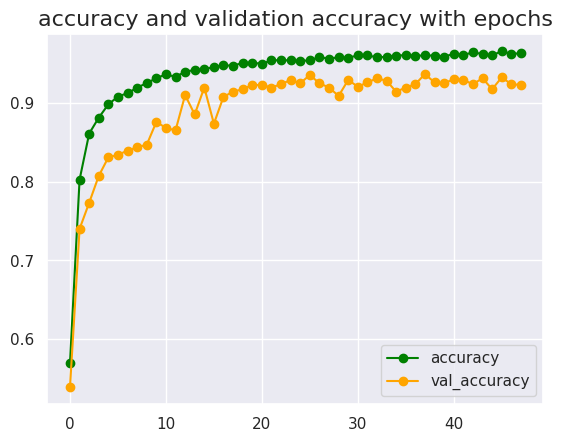

In [21]:
# plot accuracy for train and validation data.
plt.title('accuracy and validation accuracy with epochs',
          fontsize=16)

plt.plot(history.history['accuracy'],
         marker='o',
         color="green",
         label="accuracy")

plt.plot(history.history['val_accuracy'],
         marker='o',
         color="orange",
         label="val_accuracy")

plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step


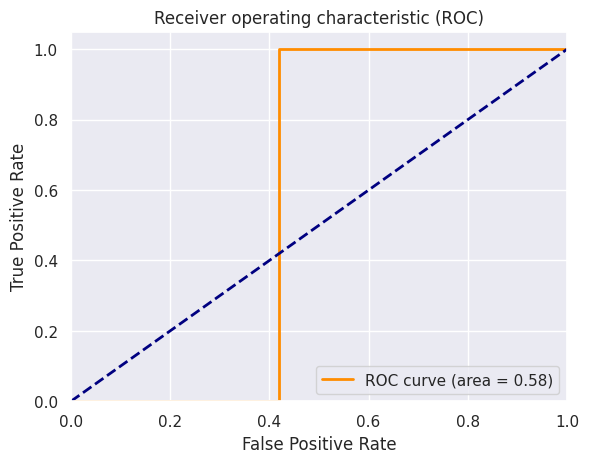

In [23]:
x, y = next(gen_train)
prediction = model.predict(x)

classes = np.argmax(prediction, axis=-1)
true_label1 = np.argmax(y, axis=-1)

y_true = np.array(true_label1)

y_pred = np.array(classes)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=9)
roc_auc = metrics.auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

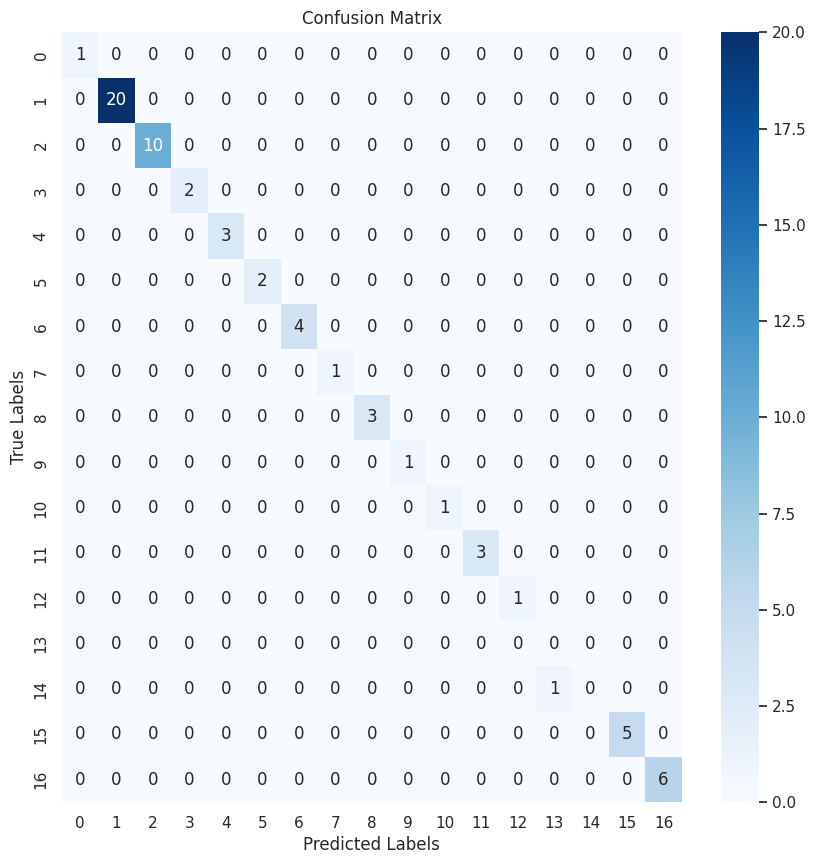

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()